In [2]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time
import random

# Quadratic loss

\begin{equation}
\min_{x \in [-1; 1]^d} \max_{y \in [-1; 1]^d} f(x,y) = (x-b_x)^T A (y - b_y) + \frac{\lambda}{2}\| x - b_x\|^2 - \frac{\lambda}{2}\| y - b_y\|^2, \lambda = 1.
\end{equation}
Под $x$ подразумевается вектор признаков, под $y - $ шум. Такой задаче ставится в соответствие оператор:
$$
F(x, y) = \begin{pmatrix}
\nabla f_x (x, y)\\
- \nabla f_y (x, y)
\end{pmatrix}
$$
Отметим, что коэффициент регуляризации $\lambda$ есть константа Липшица (а заодно и сильной выпуклости) функции $Q$ (см. дальше).

In [3]:
def generate(d = 100, m = 1, L = 1000, border=1):

    if d == 1:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]

    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    b_x = np.random.uniform(low=-border, high=border, size=(d,))
    b_y = np.random.uniform(low=-border, high=border, size=(d,))

    return A, b_x, b_y

def split(z):
    return np.split(z, 2)[0], np.split(z, 2)[1]

def merge(x, y):
    return np.concatenate((x, y), axis=None)

In [3]:
L_P = 100
m_P = 0.1
d = 100

r = 1
m_Q, L_Q = r, r

A, b_x, b_y = generate(d=d, m=m_P, L=L_P)
x0, y0 = np.random.uniform(low=-1, high=1, size=(d,)), np.random.uniform(low=-1, high=1, size=(d,))
z0 = merge(x0, y0)

In [4]:
# функции
def P_(x, y):
    return (x - b_x).T @ A @ (y - b_y)

def Q_(x, y, r=r):
    return r/2 * (np.linalg.norm(x - b_x, ord=2)**2 + np.linalg.norm(y - b_y, ord=2)**2)

def R_(x, y):
    return Q_(x, y) + P_(x, y)

# операторы, им соответствующие
def P(z):
    x, y = split(z)
    grad_x = A @ (y - b_y)
    grad_y = A.T @ (x - b_x)
    return merge(grad_x, -grad_y)

def Q(z, r=r):
    x, y = split(z)
    grad_x = r * (x - b_x)
    grad_y = -r * (y - b_y)
    return merge(grad_x, -grad_y)

def R(z):
    return Q(z) + P(z)

In [19]:
# норма оператора
def err_norm(z):
    return np.linalg.norm(R(z), ord=2)**2

# расстояние до седловой точки
def err_R(z):
    x, y = split(z)
    return np.linalg.norm(x - b_x, ord=2)**2 + np.linalg.norm(y - b_y, ord=2)**2

In [6]:
def extragradient(z0, gamma, error, iters=3000, eps=1e-12):

    z = z0
    z_vals = [z]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        w = z - gamma * R(z)
        z = z - gamma * R(w)

        z_vals.append(z)
        times.append(time.time() - start)
        err = error(z)
        errs.append(err)
        if err < eps:
            break

    return z_vals, times, errs

In [39]:
# подзадача для нашего алгоритма
def create_B(z_k, theta):
    def B(z):
        return P(z_k) + Q(z) + (z - z_k)/theta
    return B

L_B = 2 * L_P + L_Q
iters_eagv = math.ceil(9 * L_B / L_P) - 1

# ATTENTION
iters_eagv = iters_eagv // 3

def EAG_V(z0, B, iters=iters_eagv):

    z = z0
    gamma = 0.618/L_B

    for i in range(0, iters-1):
        
        w = z + (z0 - z)/(i+2) - gamma * B(z)
        z = z + (z0 - z)/(i+2)- gamma * B(w)
        gamma = gamma * (1 - (gamma * L_B)**2 / ((i+1)*(i+3)*(1 - (gamma * L_B)**2)) )

    return z

In [40]:
def extragrad_sliding(z0, gamma, theta, error, iters=3000, eps=1e-12):

    z = z0
    z_vals = [z]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        B_tmp = create_B(z, theta)
        u = EAG_V(z, B_tmp)
        z = z - gamma * R(u)

        z_vals.append(z)
        times.append(time.time() - start)
        err = error(z)
        errs.append(err)
        if err < eps:
            break

    return z_vals, times, errs

In [45]:
iters = 500
_, times1, errs1 = extragradient(z0, gamma=1/(3*L_P), error=err_R, iters=iters)
_, times2, errs2 = extragrad_sliding(z0, gamma=0.8/L_P, theta=4/L_P, error=err_R, iters=iters)

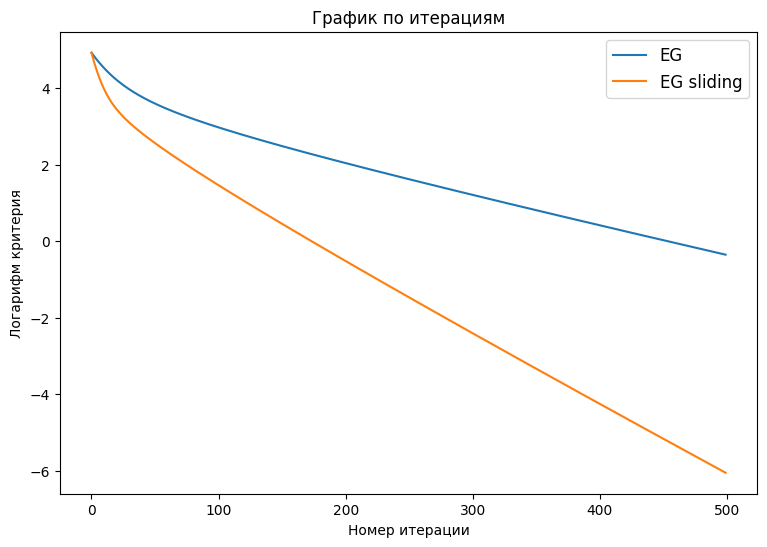

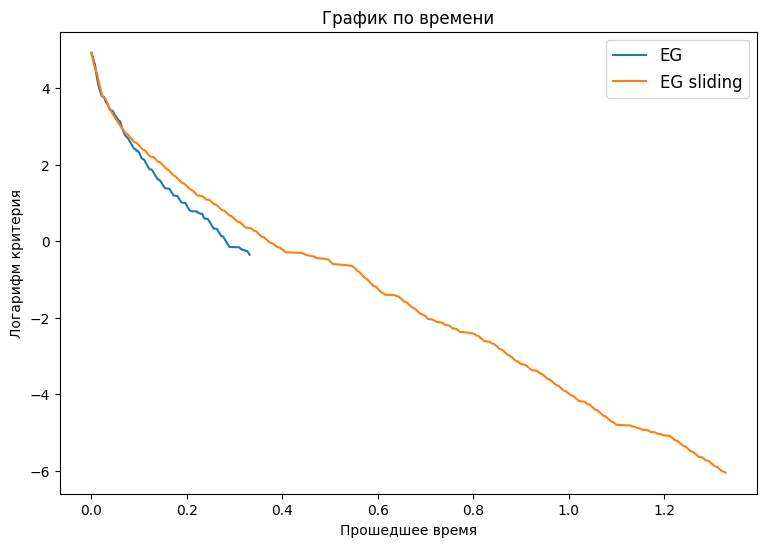

In [46]:
plt.figure(figsize=(9, 6))
plt.plot(range(len(errs1)), np.log(errs1), label='EG')
plt.plot(range(len(errs2)), np.log(errs2), label='EG sliding')
plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.title('График по итерациям')
plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(9, 6))
plt.plot(times1, np.log(errs1), label='EG')
plt.plot(times2, np.log(errs2), label='EG sliding')
plt.xlabel("Прошедшее время")
plt.ylabel("Логарифм критерия")
plt.title('График по времени')
plt.legend(fontsize=12)
plt.show()

Для лучшей сходимости отошел от теоретических параметров. Брал следующие:
1. $\gamma = \frac{0.8}{L_P}$;
2. $\theta = \frac{4}{L_P}$;
3. уменьшил число итераций подзадачи втрое.

По итерациям метод значительно обходит экстраградиентный спуск. Но его итерация слишком дорога, и по времени на этой задаче он уступил.

# Log-loss

$$ 
\underset{x}{\min} \; \underset{y}{\max} \; f(x, y) = \dfrac{1}{N} \sum \limits_{i = 0}^{N-1} \ln \left(1 + \exp (-b_i x^T (a_i + y)) \right) + \dfrac{\beta_x}{2} \|x\|^2 - \dfrac{\beta_y}{2} \|y\|^2,  \text{ где} \\
x, y \in \mathbb{R}^d, \|y\| \leq C.
$$

$x$ - вектор весов, $y$ - шум, одинаковый для всех $a_i$, $a_i$ - $i$-й вектор признаков, $b_i$ - класс $i$-го элемента.

In [8]:
from sklearn.datasets import load_svmlight_file

dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

b = 2 * b - 3
n, d = A.shape

In [67]:
from sklearn.model_selection import train_test_split
A_train, A_test, b_train, b_test = train_test_split(A, b, train_size=0.8001, shuffle=True)
n_train = A_train.shape[0]

6500

In [13]:
xxx = 0
for i in range(n):
    xxx += np.linalg.norm(A[i], ord=2)
print(xxx / n)

4.582575694956136


В среднем норма вектора признаков 4.6, поэтому буду тестировать $R$ в диапазоне $\approx 0.1 - 0.5$.

$Q$ - регуляризатор. Он выпуклый; более того, сильно выпуклый по $x$ с $\mu_x = \beta_x$ и сильно вогнутый по $\mu_y = \beta_y$. Тогда оператор, соответствующий этой функции является сильно монотонным  c $\mu = 2 \min (\beta_x, \beta_y)$.

$P$ - основная часть лосса. Она является $L$ - гладкой функцией. Оценим $L$ через значение гессиана в нуле.

In [11]:
L = 0

for i in range(A_train.shape[0]):

    hessian_i = (A_train[i].reshape((d, 1)) @ A_train[i].reshape((1, d))) / 4
    eigvals = np.linalg.eigvals(hessian_i)
    L_i = np.amax(eigvals)
    mu_i = np.amin(eigvals)

    if L_i > L:
        L = L_i
    
np.real(L)

5.25

$$
Q(z) = Q(x, y) = \begin{pmatrix}
\beta_x x \\
\beta_y y
\end{pmatrix}, 

P(z) = P(x, y) = \begin{pmatrix}
\dfrac{1}{N} \sum \limits_i \dfrac{-b_i (a_i + y)}{1 + \exp (b_i x^T(a_i+y))} \\
\dfrac{1}{N} \sum \limits_i \dfrac{b_i x}{1 + \exp (b_i x^T(a_i+y))}
\end{pmatrix},
R(z) = Q(x, y) + P(x, y).
$$

In [138]:
# parameters
beta_x = 0.1
beta_y = 0.1
C = 0.1

L_P = 5.25
L_Q = 2 * min(beta_x, beta_y)
mu_Q = L_Q

In [130]:
from numba import jit
import warnings
warnings.filterwarnings("ignore")


@jit
def Pi(z, i):
    x, y = split(z)
    px = (-b_train[i] * (A_train[i].reshape((d, 1)) + y)) / (1 + np.exp(b_train[i] * float(x.T @ (A_train[i].reshape((d, 1)) + y))))
    py = (b_train[i] * x) / (1 + np.exp(b_train[i] * float(x.T @ (A_train[i].reshape((d, 1)) + y))))
    return merge(px, py).reshape((2*d,1))

@jit
def P(z):
    p = np.zeros((2*d, 1))
    ind = [i for i in range(0, 6500, 1)]
    for i in ind:
        p += Pi(z, i)
    return p/n_train

@jit
def Q(z):
    x, y = split(z)
    return merge(beta_x * x, beta_y * y).reshape((2*d, 1))

def R(z):
    return P(z) + Q(z)

In [124]:
def proj(z):
    x, y = split(z)
    y = y * C / np.linalg.norm(y, ord=2)
    return merge(x, y).reshape((2*d, 1))

def extragradient(z0, gamma, error=err_norm, iters=3000):

    z = z0
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        w = proj(z - gamma * R(z))
        z = proj(z - gamma * R(w))

        times.append(time.time() - start)
        errs.append(error(z))

    return z, times, errs

ЧЕКАТЬ

In [158]:
def create_B(z_k, theta):
    def B(z):
        return P(z_k) + Q(z) + (z - z_k)/theta
    return B

L_B = 2 * L_P + L_Q
iters_eagv = math.ceil(9 * L_B / L_P) - 1
iters_eagv = iters_eagv // 3

def EAG_V(z0, B, iters=iters_eagv):

    z = z0
    gamma = 0.618/L_B

    for i in range(0, iters-1):
        
        w = z + (z0 - z)/(i+2) - gamma * B(z)
        z = z + (z0 - z)/(i+2)- gamma * B(w)
        gamma = gamma * (1 - (gamma * L_B)**2 / ((i+1)*(i+3)*(1 - (gamma * L_B)**2)) )

    return z

def extragrad_sliding(z0, gamma, theta, error=err_norm, iters=3000):

    z = z0
    z_vals = [z]
    times = [0.]
    errs = [error(z)]
    start = time.time()

    for i in range(0, iters-1):
        
        B_tmp = create_B(z, theta)
        u = EAG_V(z, B_tmp)
        z = z - gamma * R(u)

        z_vals.append(z)
        times.append(time.time() - start)
        errs.append(error(z))

    return z_vals, times, errs

In [161]:
x0, y0 = np.random.uniform(low=-L/5, high=L/5, size=(d,1)), np.random.uniform(low=-C, high=C, size=(d,1))
z0 = merge(x0, y0).reshape((2*d, 1))

In [162]:
iters = 20
z1, times1, errs1 = extragradient(z0, gamma=1/(2*L_P), error=err_norm, iters=iters)
#z2, times2, errs2 = extragrad_sliding(z0, gamma=1/(4*L_P), theta=4/L_P, error=err_norm, iters=iters)

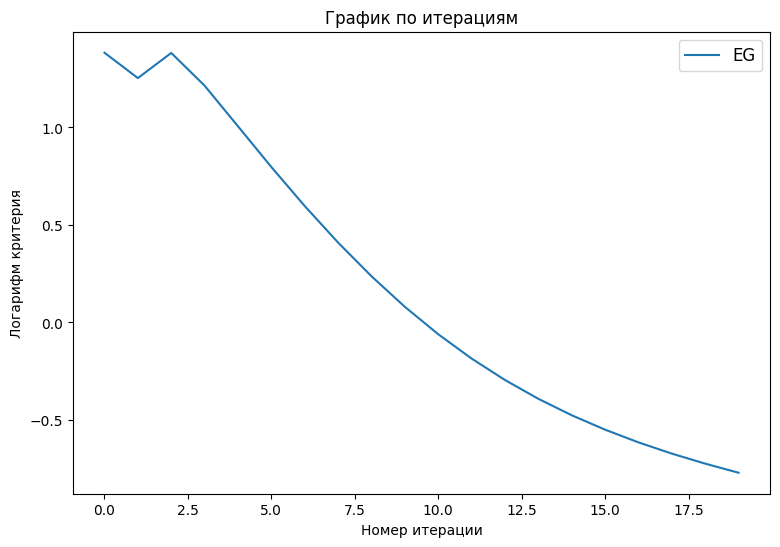

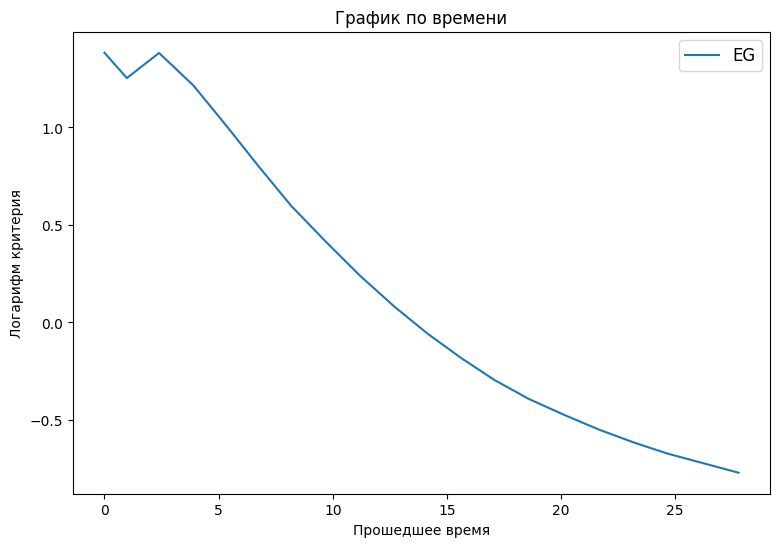

In [163]:
plt.figure(figsize=(9, 6))
plt.plot(range(len(errs1)), np.log(errs1), label='EG')
#plt.plot(range(len(errs2)), np.log(errs2), label='EG sliding')
plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.title('График по итерациям')
plt.legend(fontsize=12)
plt.show()

plt.figure(figsize=(9, 6))
plt.plot(times1, np.log(errs1), label='EG')
#plt.plot(times2, np.log(errs2), label='EG sliding')
plt.xlabel("Прошедшее время")
plt.ylabel("Логарифм критерия")
plt.title('График по времени')
plt.legend(fontsize=12)
plt.show()